____

**project**: `Lemom Quality Prediction`

**date**: `2024-10-28`

**decription**: `This notebook explores the impact of noise reduction through Canny edge detection on model performance using the Lemon Quality dataset. Various models were trained to evaluate the effectiveness of this preprocessing technique.`

**main**: `computer vision(cv) pytorch`

**architecture**:  `AlexNet`

**language**: `python`
____

### Installing Helper Packages

In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

We are also going to install `kaggle` which will allow us to interact with kaggle datasets, so that we can download the dataset that we want from kaggle.


In [1]:
!pip install helperfns opencv-python kaggle -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 4.2 MB/s eta 0:00:00


### Imports
In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [2]:
import torch
import random
import os
import time
import torchvision
import copy
import json
import cv2
import shutil

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import  classification_report
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string
from helperfns import visualization

import seaborn as sns
import pathlib
import matplotlib as mpl
import statistics as stat

torch.__version__

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


'2.5.0+cu121'

### Seed
In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.

In [3]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get the `gpu` as our device if possible for training speed.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

We are going to use the `Kaggle` API to downlod the dataset. The dataset that we are going to use in this notebook was found:

https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset

It is the dataset of lemon qualities and it contains three classes which are:

1. `good`
2. `bad`
3. `empty`

In [5]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']


In [6]:
!kaggle datasets download yusufemir/lemon-quality-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset
License(s): CC0-1.0
 93% 217M/233M [00:02<00:00, 115MB/s]
100% 233M/233M [00:02<00:00, 92.6MB/s]


To handle our dataset we are going to use the torch-vision class called `dataset.ImageFolder` and it expect the folder structure looks as follows:

```
📂set (train|test|validation)
 📂 classx
    🖼 x.png
    🖼 x.jpg
  ....

 📂 classy
    🖼 x.png
    🖼 x.jpg
    ...

*** KEY
🖼 x.png - is an image that belongs to class x.

```
In the following code cell we are going to regroup our folder structure so that the dataset will be in the format where the `ImageFolder` from torchvision expect it to be.

In [7]:
original_dataset = 'lemon_dataset'

new_dataset = "dataset"
if not os.path.exists(new_dataset):
  os.mkdir(new_dataset)

# train new dataset
if not os.path.exists(os.path.join(new_dataset, 'train')):
  os.makedirs(os.path.join(new_dataset, 'train/bad'))
  os.makedirs(os.path.join(new_dataset, 'train/empty'))
  os.makedirs(os.path.join(new_dataset, 'train/good'))

# test new dataset
if not os.path.exists(os.path.join(new_dataset, 'test')):
  os.makedirs(os.path.join(new_dataset, 'test/bad'))
  os.makedirs(os.path.join(new_dataset, 'test/empty'))
  os.makedirs(os.path.join(new_dataset, 'test/good'))

print("Done!!")

Done!!


We will need to take `20%` for each class of images and move them to the `test` folder in their respective classes.

In [8]:
test_size = .2

test_bad_size = int(len(os.listdir(os.path.join(original_dataset, 'bad_quality'))) * test_size)
test_good_size = int(len(os.listdir(os.path.join(original_dataset, 'good_quality'))) * test_size)
test_empty_size = int(len(os.listdir(os.path.join(original_dataset, 'empty_background'))) * test_size)

test_empty_size, test_good_size, test_bad_size

(90, 225, 190)

In [9]:
# test
for bad in os.listdir(os.path.join(original_dataset, 'bad_quality'))[:test_bad_size]:
    src = os.path.join(original_dataset, 'bad_quality', bad)
    dest = os.path.join(new_dataset, 'test/bad')
    shutil.move(src, dest)

for good in os.listdir(os.path.join(original_dataset, 'good_quality'))[:test_good_size]:
    src = os.path.join(original_dataset, 'good_quality', good)
    dest = os.path.join(new_dataset, 'test/good')
    shutil.move(src, dest)

for empty in os.listdir(os.path.join(original_dataset, 'empty_background'))[:test_empty_size]:
    src = os.path.join(original_dataset, 'empty_background', empty)
    dest = os.path.join(new_dataset, 'test/empty')
    shutil.move(src, dest)

# train
for bad in os.listdir(os.path.join(original_dataset, 'bad_quality')):
    src = os.path.join(original_dataset, 'bad_quality', bad)
    dest = os.path.join(new_dataset, 'train/bad')
    shutil.move(src, dest)

for good in os.listdir(os.path.join(original_dataset, 'good_quality')):
    src = os.path.join(original_dataset, 'good_quality', good)
    dest = os.path.join(new_dataset, 'train/good')
    shutil.move(src, dest)

for empty in os.listdir(os.path.join(original_dataset, 'empty_background')):
    src = os.path.join(original_dataset, 'empty_background', empty)
    dest = os.path.join(new_dataset, 'train/empty')
    shutil.move(src, dest)

print("Done!")

Done!


### AlexNet

In this notebook we will implement the modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](https://image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in `2012` by beating the second place competitor by over `10%` accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

<p align="center"><img src="https://camo.githubusercontent.com/9d77aa35c115df135ac7e36ed21484ce62146bb393dff39c241c00178f1ca8ef/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f7261772f623265393731613532643134373863386435366362343534666331343761336333343365623838322f6173736574732f616c65786e65742e706e67" alt="alexnet" width="100%"/></p>


In the following code cell we are going to create a modified version of our `Alexnet` model for doing multi-class classification on the lemon quality dataset. We are going to use [this notebook](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/03_AlexNet.ipynb) as reference.

In [10]:
class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super(AlexNet, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3, 2, 1), # in_channels, out_channels, kernel_size, stride, padding
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 192, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 64, 3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
    )

    self.classifier = nn.Sequential(
        nn.Dropout(.5),
        nn.Linear(64 * 3 * 3, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, output_dim),
    )

  def forward(self, x):
    x = self.features(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

In [11]:
OUTPUT_DIM = 3
model_1 = AlexNet(OUTPUT_DIM).to(device)
model_2 = AlexNet(OUTPUT_DIM).to(device)
model_1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): ReLU(inplace=Tru

### Image Transformations

We are going to have `2` image transformations for 2 models. The first image transformation will be for `model_1` which is the model that will train on images with background noise and `model_2` will train on images without background noise so the transformations will be as follows:

### 1. `image_tranforms_1` - `model_1`

Here are the train tranformations that will be applied.

1. `Resize((224, 224))`
2. `RandomRotation(5)`
3. `RandomHorizontalFlip(0.5)`
4. `RandomCrop(224, padding = 10)`
5. `ToTensor()`
6. `Normalize(mean = computed_means, std = computed_stds)`


And we are going to apply the following data argumentations in our `test` and `validation` sets.


1. `Resize((224, 224))`
2. `ToTensor()`
3. `Normalize(mean = computed_means, std = computed_stds)`


### 2. `image_tranforms_2` - `model_2`

Here are the train tranformations that will be applied.

1. `Resize((224, 224))`
2. `CannyEdgeDetectionAndNoiseReduction()`
3. `RandomRotation(5)`
4. `RandomHorizontalFlip(0.5)`
5. `RandomCrop(224, padding = 10)`
6. `ToTensor()`
7. `Normalize(mean = computed_means, std = computed_stds)`


And we are going to apply the following data argumentations in our `test` and `validation` sets.


1. `Resize((224, 224))`
2. `CannyEdgeDetectionAndNoiseReduction()`
3. `ToTensor()`
4. `Normalize(mean = computed_means, std = computed_stds)`


### `CannyEdgeDetectionAndNoiseReduction`

This is a custom tranformation that will be applied after the image has been resized to the required image size of `224` and it applies edge detection and noise reduction to an image using the `Canny` edge detection algorithm and OpenCV functions

https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

In the following code cell we are going to implement this custom transformation.



In [12]:
class CannyEdgeDetectionAndNoiseReduction:
    def reduce(image, bg=(0, 0, 0), display=False):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib
        edges = cv2.Canny(image, threshold1=100, threshold2=200)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        masked = cv2.bitwise_or(image, edges)
        masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
        if display:
            # Display the result
            plt.subplot(1, 3, 1)
            plt.imshow(image_rgb)
            plt.title("Original Image", fontsize=8)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
            plt.title("Canny Image", fontsize=8)
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(masked)
            plt.title("Bitwise Or", fontsize=8)
            plt.axis("off")
        return masked

    def __call__(self, image):
        img = CannyEdgeDetectionAndNoiseReduction.reduce(image)
        img = Image.fromarray(img.astype('uint8'), 'RGB')
        return img

Next let's see how this transformation works by visualizing how it transform lemon images for each class.

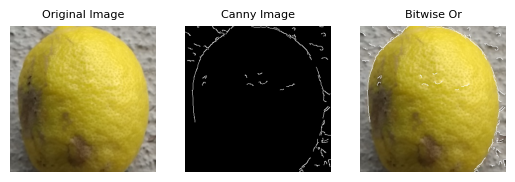

In [13]:
bad_image = os.path.join('dataset/train/bad', os.listdir(os.path.join('dataset', 'train', 'bad'))[3])
_ = CannyEdgeDetectionAndNoiseReduction.reduce(Image.open(bad_image), display=True)

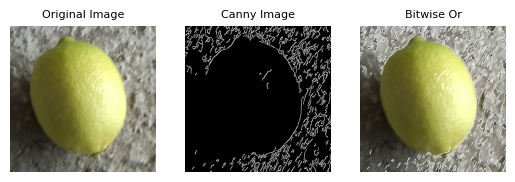

In [14]:
good_image = os.path.join('dataset/train/good', os.listdir(os.path.join('dataset', 'train', 'good'))[5])
_ = CannyEdgeDetectionAndNoiseReduction.reduce(Image.open(good_image), display=True)

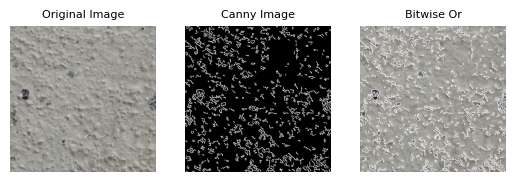

In [15]:
empty_image = os.path.join('dataset/train/empty', os.listdir(os.path.join('dataset', 'train', 'empty'))[0])
_ = CannyEdgeDetectionAndNoiseReduction.reduce(Image.open(empty_image), display=True)

Next we are going to compute the `means` and `stds` that we are goint to use for the transformation of images during data argumentation.

In [16]:
train_data_1 = datasets.ImageFolder(
    root='./dataset/train',
    transform= transforms.ToTensor()
)

means_1 = torch.zeros(3)
stds_1 = torch.zeros(3)

for img, label in train_data_1:
  means_1 += torch.mean(img, dim = (1,2))
  stds_1 += torch.std(img, dim = (1,2))

means_1 /= len(train_data_1)
stds_1 /= len(train_data_1)

print(f'Calculated means_1: {means_1}')
print(f'Calculated stds_1: {stds_1}')

Calculated means_1: tensor([0.5562, 0.5194, 0.3515])
Calculated stds_1: tensor([0.1777, 0.1757, 0.1806])


In [17]:
train_data_2 = datasets.ImageFolder(
    root='./dataset/train',
    transform = transforms.Compose([CannyEdgeDetectionAndNoiseReduction(), transforms.ToTensor()])
)

means_2 = torch.zeros(3)
stds_2 = torch.zeros(3)

for img, label in train_data_2:
  means_2 += torch.mean(img, dim = (1,2))
  stds_2 += torch.std(img, dim = (1,2))

means_2 /= len(train_data_2)
stds_2 /= len(train_data_2)

print(f'Calculated means_2: {means_2}')
print(f'Calculated stds_2: {stds_2}')

Calculated means_2: tensor([0.5895, 0.5539, 0.3909])
Calculated stds_2: tensor([0.2122, 0.2145, 0.2401])


In [18]:
image_transforms_1 = {
    "train": transforms.Compose([
              transforms.Resize((224, 224)),
              transforms.RandomRotation(5),
              transforms.RandomHorizontalFlip(.5),
              transforms.RandomCrop(224, padding=2),
              transforms.ToTensor(),
              transforms.Normalize(mean=means_1, std=stds_1, inplace=False)
          ]),
    "valid": transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean = means_1,
                            std = stds_1)
        ]),
    "test": transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean = means_1,
                            std = stds_1)
    ])
}

image_transforms_2 = {
    "train": transforms.Compose([
              transforms.Resize((224, 224)),
              CannyEdgeDetectionAndNoiseReduction(),
              transforms.RandomRotation(5),
              transforms.RandomHorizontalFlip(.5),
              transforms.RandomCrop(224, padding=2),
              transforms.ToTensor(),
              transforms.Normalize(mean=means_2, std = stds_2, inplace=False)
          ]),
    "valid": transforms.Compose([
          transforms.Resize((224, 224)),
          CannyEdgeDetectionAndNoiseReduction(),
          transforms.ToTensor(),
          transforms.Normalize(mean = means_2, std = stds_2, inplace=False)
        ]),
    "test": transforms.Compose([
          transforms.Resize((224, 224)),
          CannyEdgeDetectionAndNoiseReduction(),
          transforms.ToTensor(),
          transforms.Normalize(mean = means_2, std = stds_2, inplace=False)
    ])
}

### Loading our custom Data

Next we are going to create 2 dataset with different transformations using the `datasets.ImageFolder` from `torchvision` for  train and test sets.

In [19]:
image_datasets_1 = {
    x: datasets.ImageFolder(
        os.path.join('dataset', x),
        transform = image_transforms_1[x]
    ) for x in os.listdir(new_dataset)
}

image_datasets_2 = {
    x: datasets.ImageFolder(
        os.path.join('dataset', x),
        transform = image_transforms_2[x]
    ) for x in os.listdir(new_dataset)
}

Let's get the class names in our dataset.

In [20]:
assert image_datasets_1['train'].classes == image_datasets_2['train'].classes, "The classes are not the same"

class_names = image_datasets_2["train"].classes
class_names

['bad', 'empty', 'good']

We can also get classes to index which shows us the classname pared to the integer representation of that class.

In [21]:
image_datasets_1['train'].class_to_idx

{'bad': 0, 'empty': 1, 'good': 2}

Now we can create a validation data from the train set.

> Note that the validation data will come from the `train` set. We are going to take a ratio of `20%` and give it to the validation set and then the rest will remain in the train data.

In [22]:
train_data_1 = image_datasets_1["train"]
test_data_1= image_datasets_1["test"]

train_data_2 = image_datasets_2["train"]
test_data_2= image_datasets_2["test"]

VALID_RATIO = 0.8
n_train_examples = int(len(train_data_1) * VALID_RATIO)
n_valid_examples = len(train_data_1) - n_train_examples

train_data_1, valid_data_1 = data.random_split(train_data_1,
                                           [n_train_examples, n_valid_examples])
train_data_2, valid_data_2 = data.random_split(train_data_2,
                                           [n_train_examples, n_valid_examples])

Overiding the transforms of the train on the validation set with the validation transforms that we have defined previously.

In [23]:
valid_data_1 = copy.deepcopy(valid_data_1)
valid_data_1.dataset.transform = image_transforms_1['valid']

valid_data_2 = copy.deepcopy(valid_data_2)
valid_data_2.dataset.transform = image_transforms_2['valid']

In the following code cell we are going to check how examples are distributed in each set.

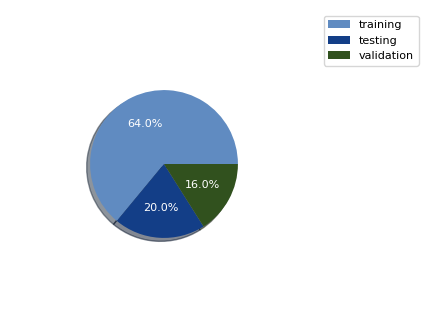

In [24]:
assert len(train_data_1) == len(train_data_2), "The lengths are not the same"
assert len(valid_data_1) == len(valid_data_2), "The lengths are not the same"
assert len(test_data_1) == len(test_data_2), "The lengths are not the same"

examples	= dict([
    ("training", len(train_data_1)),
    ("testing", len(test_data_1)),
    ("validation", len(valid_data_1))
])
plt.figure(figsize=(4, 4))
plt.pie(examples.values(), labels=examples.keys(),
        pctdistance=0.6, shadow=True, autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#608BC1', '#133E87', '#31511E'])
plt.legend(fontsize=8, labels=list(examples.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Iterators

Our model has significantly more parameters and the images it is training on are much larger so will generally take longer. We offset this as much as we can by using a batch size of `128`.

In [25]:
BATCH_SIZE = 128

train_iterator_1 = data.DataLoader(
    train_data_1, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator_1 = data.DataLoader(
    valid_data_1, batch_size= BATCH_SIZE
)
test_iterator_1 = data.DataLoader(
    test_data_1,  batch_size= BATCH_SIZE
)


train_iterator_2 = data.DataLoader(
    train_data_2, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator_2 = data.DataLoader(
    valid_data_2, batch_size= BATCH_SIZE
)
test_iterator_2 = data.DataLoader(
    test_data_2,  batch_size= BATCH_SIZE
)

### Visualizing Images
Now we can go ahead and visualize the images that we are having in this dataset.

In [26]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In the following code cell we are going to define a function that will plot the normalised images from our datasets.

In [27]:
def plot_images(images, labels, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(class_names[labels[i]], fontsize=10)
    ax.axis('off')

Let's first plot the images without noise reduction.

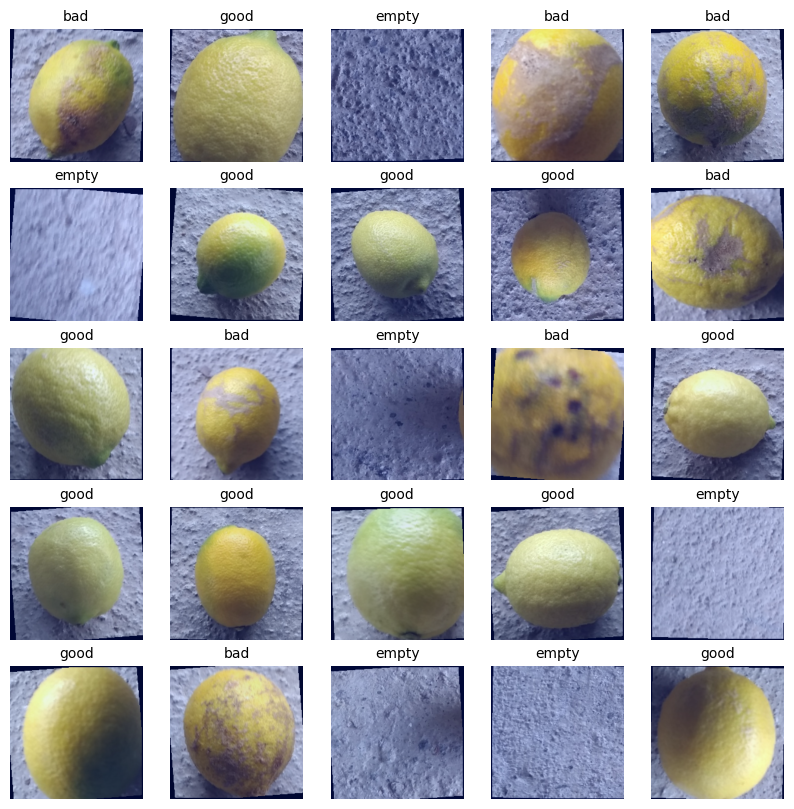

In [28]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [train_data_1[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

Let's first plot the images after the noise has been reduced.

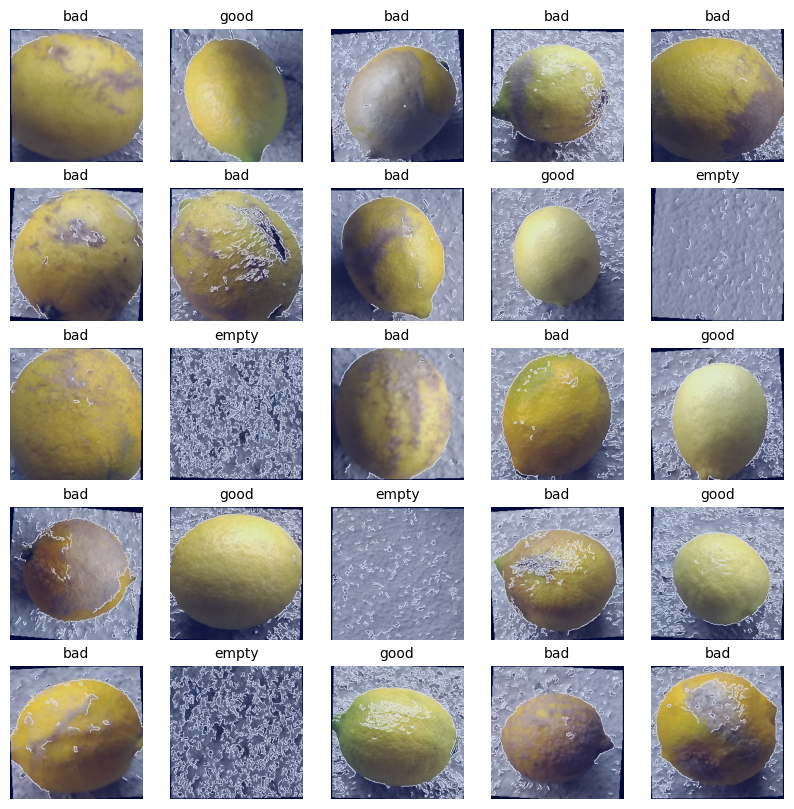

In [29]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [train_data_2[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

### Counting model Parameters
In the following code cell we are going to count the `model` parameters of our models.

> These 2 models shoud have equal number of parameters.

In [30]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return total_params, trainable_params

total_params_1, trainable_params_1 = count_params(model_1)
total_params_2, trainable_params_2 = count_params(model_2)

tabulate_data(["","Total Parameters", "Trainable Parameteres"],
           [["model_1", f'{total_params_1:,}', f'{trainable_params_1:,}'],
            ["model_2",f'{total_params_2:,}',  f'{trainable_params_2:,}']],
           "MODEL PARAMETERS")

MODEL PARAMETERS
+---------+------------------+-----------------------+
|         | Total Parameters | Trainable Parameteres |
+---------+------------------+-----------------------+
| model_1 |       21,777,411 |            21,777,411 |
| model_2 |       21,777,411 |            21,777,411 |
+---------+------------------+-----------------------+


### Models Training

In the following code cell we are going to create create `optimizers` and `criterions` for our models.

> Note that for the optimizer we are going to use the `Adam` with default parameters and `CrossEntropyLoss` as our loss function since it is a multi-class classification.

In [31]:
optimizer_1 = torch.optim.Adam(model_1.parameters())
criterion_1 = nn.CrossEntropyLoss().to(device)

optimizer_2 = torch.optim.Adam(model_2.parameters())
criterion_2 = nn.CrossEntropyLoss().to(device)

### Categorical Accuracy Function.
In the following code cell we are going to define our `categorical_accuracy` function which is a function that caculate the categorical accuracy between predicted labels and real labels.

In [32]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluation Function

1. `train`
* first we put the model in the train mode by calling the `model.train()`
* We will iterate over the iterator and put `labels` and features(`images`) to the `device`
*  we call the `optimizer.zero_grad()` to restore the gradients of the optimizer for each iteration
* we make predictions and calculate the `accuracy` and `loss`
* we then updates the weights by calling `optimizer.step()` after backward propergation using the `loss.backward()`
* we will return the `loss` and the `accuracy`

2. `evaluate`
* we put the model in evaluation mode by calling `model.eval()`
* we wrap our loop with `torch.no_grad()` beacuse we are not interested in calculating the gradients during model evaluation.
* We calculate the `loss` and `accuracy` and return them
Our train and evaluate function are as follows:

In [33]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).long()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).long()
      y_pred, _ = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `20` epochs. We are going to keep in track of the model training history so that we can visualize it later on.

Let's create a history container that will store our training history values.

In [34]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Next we are going to create a function called `train_model` which takes in the model to be trained and a model name.

In [35]:

EPOCHS = 20
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch


In [36]:
history_1, training_end_1, last_saved_epoch_1 = train_model(
    model_1, 'model-1.pt', train_iterator_1,
    optimizer_1, criterion_1, device, valid_iterator_1
)

model-1: EPOCH 01/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.100 |   43.25% | 0:00:12.97 |
| Validation | 1.051 |   40.95% |            |
+------------+-------+----------+------------+
model-1: EPOCH 02/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.850 |   51.80% | 0:00:11.72 |
| Validation | 0.667 |   71.96% |            |
+------------+-------+----------+------------+
model-1: EPOCH 03/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.476 |   80.22% | 0:00:11.66 |
| Validation | 0.387 |   84.91% |            |
+------------+-------+----------+------------+
model-1: EPOCH 04/20: (saving)
+------------+-------+--------

In [37]:
history_2, training_end_2, last_saved_epoch_2 = train_model(
    model_2, 'model-2.pt', train_iterator_2,
    optimizer_2, criterion_2, device, valid_iterator_2
)

model-2: EPOCH 01/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 1.062 |   40.06% | 0:00:14.10 |
| Validation | 0.979 |   39.80% |            |
+------------+-------+----------+------------+
model-2: EPOCH 02/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.679 |   63.78% | 0:00:14.24 |
| Validation | 0.537 |   77.04% |            |
+------------+-------+----------+------------+
model-2: EPOCH 03/20: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.452 |   79.80% | 0:00:14.07 |
| Validation | 0.431 |   85.49% |            |
+------------+-------+----------+------------+
model-2: EPOCH 04/20: (saving)
+------------+-------+--------

### Visualizing the training History
In this section of the notebook we are going to visualize the training history for each model inform of a table over `N` epochs.

In [38]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}', f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch_1}', f'{last_saved_epoch_2}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end_1)}', f'{hms_string(training_end_2)}']
]
tabulate_data(['', 'model_1', 'model_2'], rows, "TOTAL TRAINING TIME")

TOTAL TRAINING TIME
+---------------------+------------+------------+
|                     |    model_1 |    model_2 |
+---------------------+------------+------------+
| TOTAL EPOCHS        |         20 |         20 |
| LAST SAVED EPOCH    |         15 |         20 |
| TOTAL TRAINING TIME | 0:03:50.51 | 0:04:40.86 |
+---------------------+------------+------------+


Let's plot how long the model took to train each epoch from our `history` object.

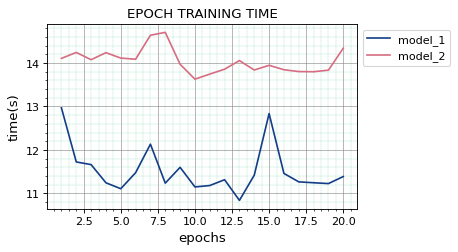

In [39]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history_1.epoch_train_time, label="model_1", color="#133E87")
plt.plot(epochs, history_2.epoch_train_time, label="model_2", color="#D76C82")
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Let's plot the model's training history in terms of `acuracy` over a period of `N` epochs in our `train` set for ``model_1`` and ``model_2``.

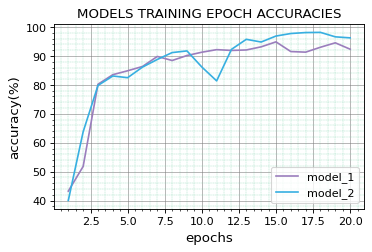

In [40]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [i * 100 for i in history_1.train_acc], label="model_1", color="#9B7EBD")
plt.plot(epochs, [i * 100 for i in history_2.train_acc], label="model_2", color="#37AFE1")

plt.title("MODELS TRAINING EPOCH ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Let's plot the model's training history in terms of `acuracy` over a period of `N` epochs in our `validation` set for ``model_1`` and ``model_2``.

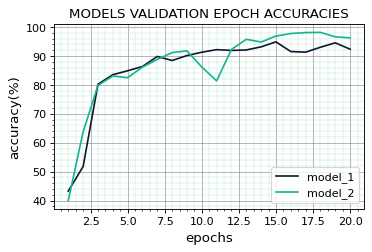

In [41]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [i * 100 for i in history_1.train_acc], label="model_1", color="#0B192C")
plt.plot(epochs, [i * 100 for i in history_2.train_acc], label="model_2", color="#15B392")

plt.title("MODELS VALIDATION EPOCH ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Let's plot the model's training history in terms of `losses` over a period of `N` epochs in our `train` set for `model_1` and `model_2`.

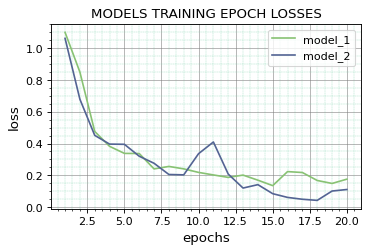

In [42]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)

plt.plot(epochs, history_1.train_losses, label="model_1", color="#88C273")
plt.plot(epochs, history_2.train_losses, label="model_2", color="#536493")

plt.title("MODELS TRAINING EPOCH LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Let's plot the model's training history in terms of `losses` over a period of `N` epochs in our `validation` set for `model_1` and `model_2`.

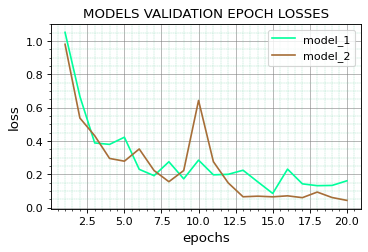

In [43]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)

plt.plot(epochs, history_1.val_losses, label="model_1", color="#00FF9C")
plt.plot(epochs, history_2.val_losses, label="model_2", color="#A66E38")

plt.title("MODELS VALIDATION EPOCH LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(bbox_to_anchor=(1, 1))

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Next we are going to `evaluate` the best models and check for the model `losses` and `accuracies` based on the `unseen` dataset which is the `test` for both `model_1` and `model_2`.

In [44]:
model_1.load_state_dict(torch.load('model-1.pt', weights_only=True))
model_2.load_state_dict(torch.load('model-2.pt', weights_only=True))

test_loss_1, test_acc_1 = evaluate(model_1, test_iterator_1, criterion_1, device)
test_loss_2, test_acc_2 = evaluate(model_2, test_iterator_2, criterion_2, device)

xs = np.array(['model_1', 'model_2'])
losses = np.array([test_loss_1, test_loss_2])
accuracies = np.array([test_acc_1, test_acc_2]) * 100

Let's check the models accuracies and lossed based on the `test` data.

In [45]:
print(f"model_1 accuracy:\t {accuracies[0]:.2f}%")
print(f"model_2 accuracy:\t {accuracies[1]:.2f}%")

print(f"model_1 loss:\t\t {losses[0]:.3f}")
print(f"model_2 loss\t\t {losses[1]:.3f}")

model_1 accuracy:	 95.59%
model_2 accuracy:	 97.82%
model_1 loss:		 0.110
model_2 loss		 0.065


Next we are going to visualize the models losses using a bar graph.

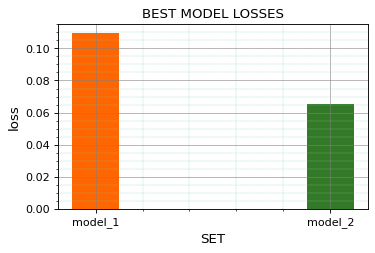

In [46]:
plt.figure(figsize=(5, 3), dpi=80)
plt.bar(xs, losses, label= xs, width=.2, color=['#FF6500', '#347928'], align="center")
plt.title("BEST MODEL LOSSES", color="k", fontsize=12)
plt.xlabel("SET", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Next we are going to visualize model accuracies based on the tests data.

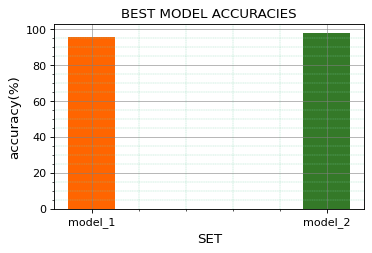

In [47]:
plt.figure(figsize=(5, 3), dpi=80)
plt.bar(xs, accuracies, label= xs, width=.2, color=['#FF6500', '#347928'], align="center")
plt.title("BEST MODEL ACCURACIES", color="k", fontsize=12)
plt.xlabel("SET", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the metrics. We are going to use the following evaluation methods on this classification task.

1. `confusion matrix`.
2. `classification report`.
3. `f1_score`
4. `precision`
5. `recall`


First of all we need to get the actual values and predicted values from the `test_iteraror` so that we will be able to use all the examples in the test dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. `images` - the image to be predicted
2. `labels` - the actual image label
3. `probs` - the list of probabilities for the image to belong to a certain class.




In [48]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, 1).squeeze().detach()
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob)
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

Let's go ahead and get the `images`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [49]:
test_images_1, test_labels_1, probs_1 = get_predictions(model_1, test_iterator_1, device)
test_images_2, test_labels_2, probs_2 = get_predictions(model_2, test_iterator_2, device)

In [50]:
preds_1 = torch.argmax(probs_1, 1)
preds_2 = torch.argmax(probs_2, 1)

### Ploting predictions
Now that we have our `predicted` labels and `actual` labels from the `test` dataset. We can use them to visualize how good the model is performing during inference. Let's define a function called `plot_predictions_images` which plots the predicted images together with their labels.

In [51]:
test_images_labels_1 = list(zip(test_images_1, preds_1, test_labels_1))
test_images_labels_2 = list(zip(test_images_2, preds_2, test_labels_2))

random.shuffle(test_images_labels_1)
random.shuffle(test_images_labels_2)


y_true_1 = []
y_pred_1 = []
y_true_2 = []
y_pred_2 = []
images_1 = []
images_2 = []

for img, pred, label in test_images_labels_1[:24]:
  y_true_1.append(label)
  y_pred_1.append(pred.cpu().item())
  images_1.append(img)

for img, pred, label in test_images_labels_2[:24]:
  y_true_2.append(label)
  y_pred_2.append(pred.cpu().item())
  images_2.append(img)


y_true_1 = np.array(y_true_1)
y_pred_1 = np.array(y_pred_1)
y_true_2 = np.array(y_true_2)
y_pred_2 = np.array(y_pred_2)


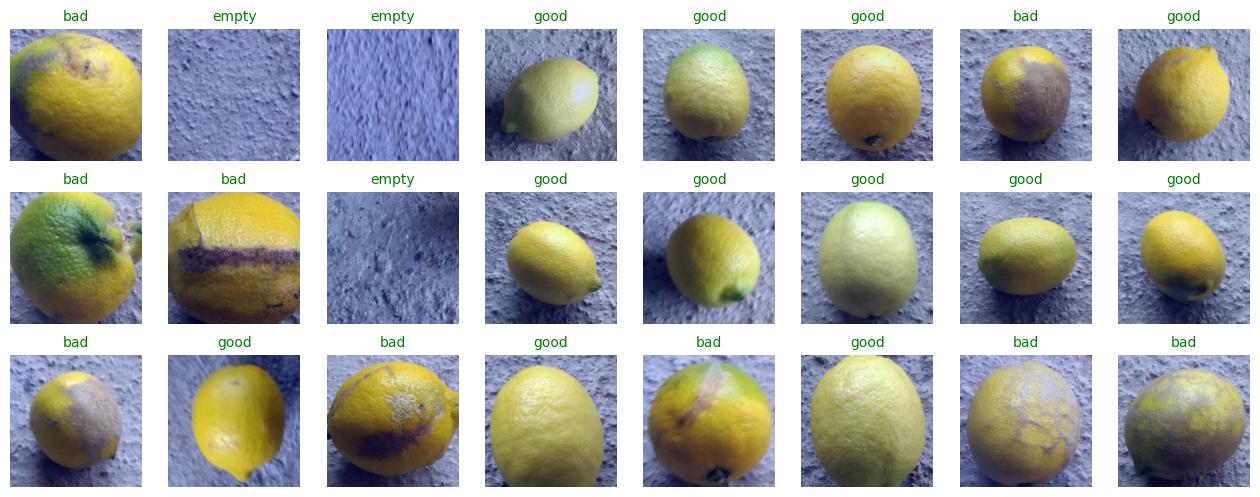

In [52]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images_1[:24], y_true_1[:24], y_pred_1[:24], cols=8)

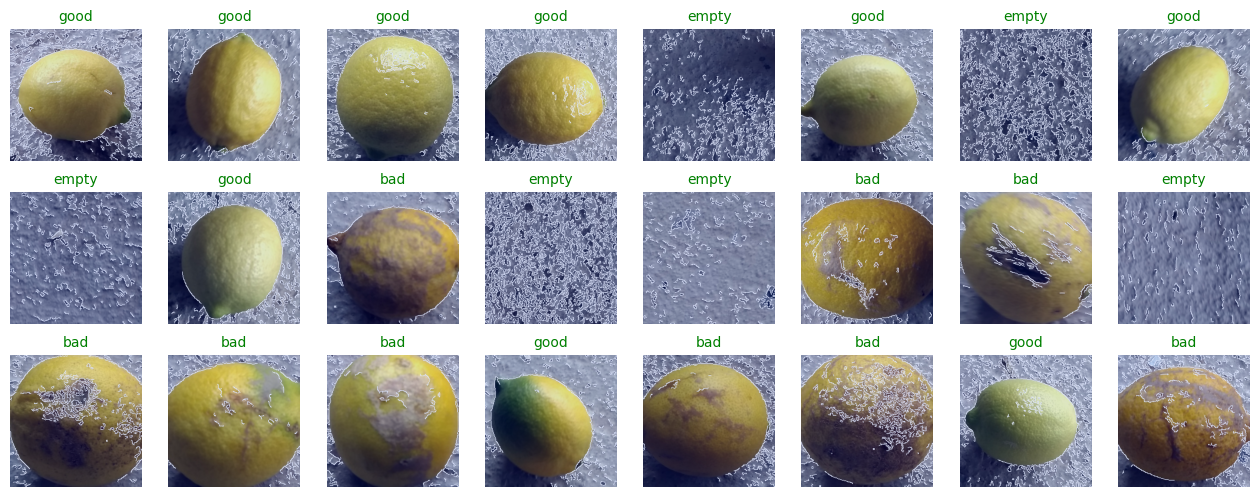

In [53]:
plot_predictions_images(images_2[:24], y_true_2[:24], y_pred_2[:24], cols=8)

From the above visualization the images that has a `red` title are `mis-classified` by the model and the one in `green` was classified well by the model.


### The confusion matrix

Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting images in the `test` set. We are going to use a function called `plot_complicated_confusion_matrix` from `helperfns.visualization` in the following code cell, this function will take in the `real-labels`, `predicted labels` together with the classes.

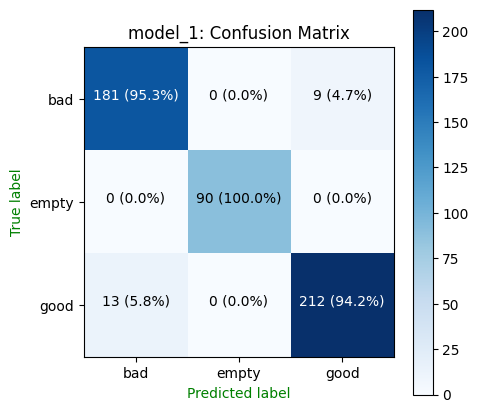

In [54]:
plot_complicated_confusion_matrix(test_labels_1, preds_1.cpu(), class_names,
                                  fontsize=10, figsize=(5, 5), title="model_1: Confusion Matrix")

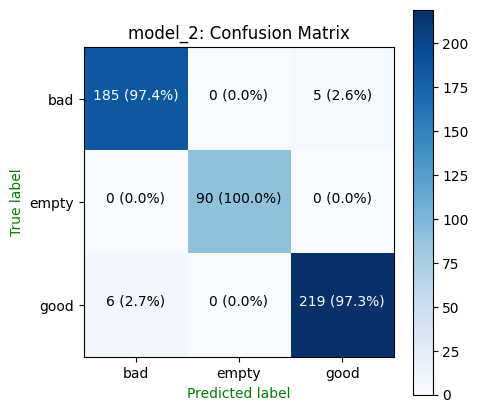

In [55]:
plot_complicated_confusion_matrix(test_labels_2, preds_2.cpu(), class_names,
                                  fontsize=10, figsize=(5, 5), title="model_2: Confusion Matrix")

### Classification report

In the following code cell we are going to print the classification report as a way of measuring how good each model perfomed in classification of lemon quality.

In [56]:
cr_1 = classification_report(test_labels_1, preds_1.cpu(), output_dict=False)
print(cr_1)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       190
           1       1.00      1.00      1.00        90
           2       0.96      0.94      0.95       225

    accuracy                           0.96       505
   macro avg       0.96      0.96      0.96       505
weighted avg       0.96      0.96      0.96       505



In [57]:
cr_2 = classification_report(test_labels_2, preds_2.cpu(), output_dict=False)
print(cr_2)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       190
           1       1.00      1.00      1.00        90
           2       0.98      0.97      0.98       225

    accuracy                           0.98       505
   macro avg       0.98      0.98      0.98       505
weighted avg       0.98      0.98      0.98       505



Next let's plot the classification report, for each model.

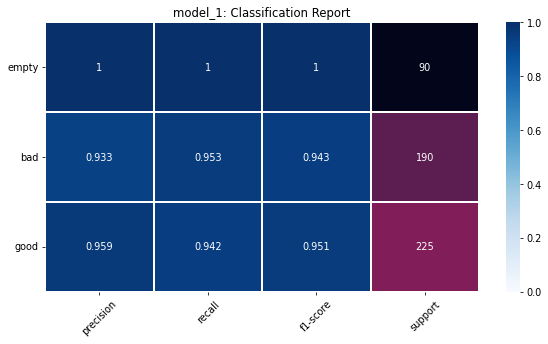

In [58]:
fig, ax = visualization.plot_classification_report(test_labels_1, preds_1.cpu(),
                    title='model_1: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = class_names)

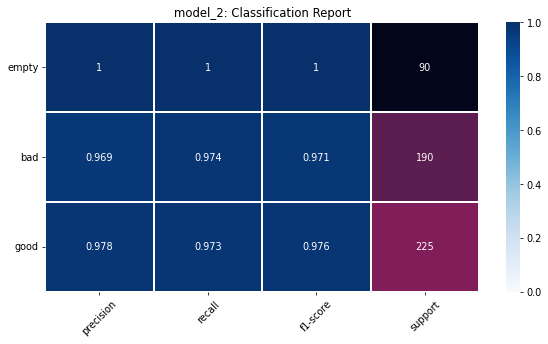

In [59]:
fig, ax = visualization.plot_classification_report(test_labels_2, preds_2.cpu(),
                    title='model_2: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = class_names)

### Incorrect predictions

We can get all the correct predictions and filter out all the incorrect predictions sort them out based on how confident they were on their incorrect prediction.

In [60]:
corrects_1 = torch.eq(test_labels_1, torch.from_numpy(preds_1.cpu().numpy()))
corrects_2 = torch.eq(test_labels_2, torch.from_numpy(preds_2.cpu().numpy()))

Getting incorrect predicted examples...

In [61]:
probabilities_1 = torch.tensor([float(probs_1[i][torch.argmax(probs_1[i])].detach().cpu().numpy()) for i in preds_1])
probabilities_2 = torch.tensor([float(probs_2[i][torch.argmax(probs_2[i])].detach().cpu().numpy()) for i in preds_2])

In [62]:
def get_incorrect_examples(images, labels, probabilities, corrects):
  incorrect_examples = []
  for image, label, prob, correct in zip(images, labels, probabilities, corrects):
    if not correct:
      incorrect_examples.append((image, label, prob))
  return incorrect_examples

incorrect_examples_1 = get_incorrect_examples(test_images_1, test_labels_1, probabilities_1, corrects_1)
incorrect_examples_2 = get_incorrect_examples(test_images_2, test_labels_2, probabilities_2, corrects_2)

incorrect_examples_1.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
incorrect_examples_2.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class.

In [63]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (6, 4))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_class = classes[true_label]
    incorrect_class = classes[0 if true_label == 1 else 1]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'real: {true_class}\n' \
                  f'predicted: {incorrect_class}', fontsize=8)
    ax.axis('off')
  fig.subplots_adjust(hspace=0.4)

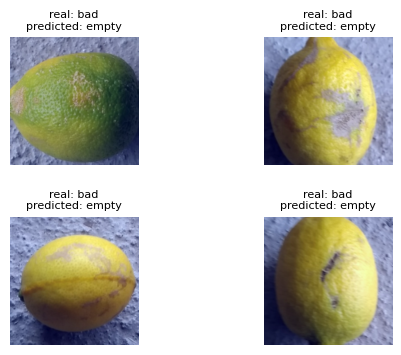

In [64]:
N_IMAGES = 8
plot_most_incorrect(incorrect_examples_1, class_names, N_IMAGES)

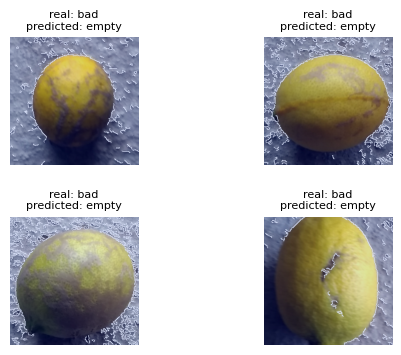

In [65]:
N_IMAGES = 8
plot_most_incorrect(incorrect_examples_2, class_names, N_IMAGES)